In [7]:
import random
import os
import time
import numpy as np


def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    

set_seed(0) # for reproducibility of random modules if used

# Data Parsing:
- When used in pipeline, data may come in different formats like json etc. 

In [1]:

tweets = []

temp = {}

with open("data/train.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip().lower()
        arr = line.split('\t')
        if len(arr)==3:
            tweets.append(temp)
            temp = {}
            temp['id'] = arr[1]
            if arr[2] == 'negative':
                temp['label'] = 2
            elif arr[2] == 'positive':
                temp['label'] = 1
            elif arr[2] == 'neutral':
                temp['label'] = 0
            else:
                print('Error here')
                print(arr)
                break
        elif len(arr)==2:
            if 'tokens' in temp:
                temp['tokens'].append(arr)
            else:
                temp['tokens'] = [arr]

tweets.pop(0)

{}

# Data Preprocessing:
- Removal of stopwords related to english and also hinglish, urls, usernames etc followed by tokenizing.
- This part mostly comes under the data collection pipeline, for example: collecting the tweets/ feedbacks from different channels and having a service like **AWS Lambda** which processes the text before storing them in a database like **S3**.
- Some of the problems which may occur as the pipeline scales is handling all types of texts pertaining to single language, multilingual, Code mixed text etc.

In [2]:
import nltk
nltk.download("stopwords")
import re
from nltk.tokenize import casual_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sns
import pandas as pd
import numpy as np

with open("data/stop_hinglish.txt", "r") as in_file:
    hinglish = in_file.readlines()
hinglish = [word.strip() for word in hinglish]
union_stopwords = (set(stopwords.words('english')) | set(hinglish))-{'t'}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gampa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
patterns = {
    'urls': '(https?:?(\s)*\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.+(\s)*)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', #urls with optional spaces which is the case here
    'usernames': '@(\s)*[\w]+'
}
X,x_bert, y = [], [], []
for i in range(len(tweets)):
    phrase = ''
    for word in tweets[i]['tokens']:
        word = word[0]
        if word.lower() in union_stopwords:
            pass
        else:
            phrase += (' ' + word) if len(phrase) != 0 else word

    phrase = re.sub(patterns['urls'], "", phrase)
    phrase = re.sub(patterns['usernames'],"",phrase)
    phrase = ' '.join(casual_tokenize(phrase, reduce_len=True, strip_handles=True))
    X.append(phrase)
    x_bert.append(phrase)
    y.append(tweets[i]['label'])

- More pre-processing techniques like lemmatisation/normalisation can also be done. Since these are language dependent, we can use the language labels for each word while processing. Some of the problems which are possible are: all languages don't have the support of lemmatisation, specifically the low resource languages. Maybe use language agnostic normalisation techniques like neural stemming or neural lemmatisation.
- In practice, we may not have the language labels by default while collecting the data from different channels, we have to have an overhead for language annotations before the preprocessing steps. 
- If we can have models that achieve good score without some of the preprocessing techniques with high computational overhead, then those pre_processing techniques can be ignored. 

# Model Training Part:
## Exploratory analysis

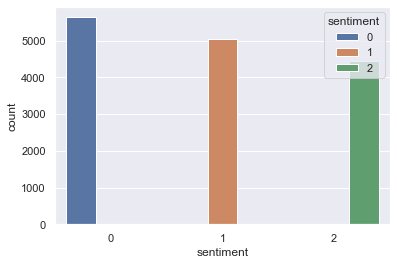

In [4]:
df = pd.DataFrame()
df["tweet"] = X
df["sentiment"] = y
sns.set(style="darkgrid")
sns.countplot(x='sentiment', data=df, hue='sentiment') # class distributions, have to take special care when the dataset is imbalanced


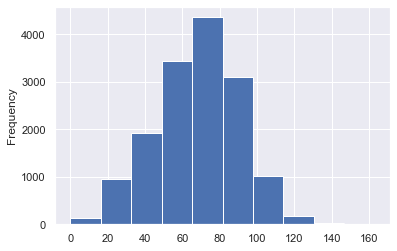

In [5]:
length = df['tweet'].str.len().plot.hist(figsize = (6, 4)) # distribution of the tweet lengths, more inference time for large length texts

## Feauture Extraction/ Feature Engineering:
- There are different ways of converting the texts to vectors (Or) extracting features from words in the vocabulary like bag of words, tf-idf etc. 
- Or using pretrained embeddings like word2vec, glove etc. For code mixed data, the vectors corresponding to the two different languages have to be present in a common vector space. For example, fast text has **aligned** vectors [https://fasttext.cc/docs/en/aligned-vectors.html] which has mutlilingual text embeddings in a common vector space. Here **language labels** can be used while converting each word to a vector. 
- If not for pretrained, we can train our own embeddings through an embedding layer if neural networks are used Or fit a custom word2vec on the data vocabulary we have. Drawbacks: poor representations if the data is less. Maybe using pretrained multilingual versions of BERT or GPT is a better solution. 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(X).toarray()
y = np.array(y)
# Splitting the data sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42) #K fold cv is robust to the splitting of dataset

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13617, 2500)
(1513, 2500)
(13617,)
(1513,)


In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model training:
- Once we have the preprocessed data, we need to decide the model architectures. Sometimes, it is also possible that we may need to use ensemble of different architectures. This also involves hyperparamter tuning etc. This process is mostly done offline.
- And it is also good to do different ablations corresponding to different preprocessing techniques. For example, if the final accuracy of the best model doesn't differ much when one preprocessing tecchnique is removed, we can ignore this for improving the overall latency.
- While I have used non deep learning based architectures in this notebook, deep learning architectures like RNN, CNN can also be used with softmax layer at the output with three classes.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report
import time

model = RandomForestClassifier()

t0 = time.time()
model.fit(X_train, y_train)
t1 = time.time()
y_pred = model.predict(X_test)
t2 = time.time()
time_train = t1-t0
time_predict = t2-t1


print("Results for RandomForest")
print("Training time: %fs; Prediction time: %fs" % (time_train, time_predict))
print(classification_report(y_test, y_pred))


Results for RandomForest
Training time: 123.279668s; Prediction time: 0.248341s
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       587
           1       0.61      0.60      0.61       486
           2       0.59      0.59      0.59       440

    accuracy                           0.56      1513
   macro avg       0.57      0.57      0.57      1513
weighted avg       0.56      0.56      0.56      1513



In [9]:
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier()

t0 = time.time()
model.fit(X_train, y_train)
t1 = time.time()
y_pred = model.predict(X_test)
t2 = time.time()
time_train = t1-t0
time_predict = t2-t1


print("Results for DecisionTree")
print("Training time: %fs; Prediction time: %fs" % (time_train, time_predict))
print(classification_report(y_test, y_pred))

Results for DecisionTree
Training time: 80.127704s; Prediction time: 0.015960s
              precision    recall  f1-score   support

           0       0.47      0.50      0.48       587
           1       0.55      0.52      0.53       486
           2       0.53      0.52      0.52       440

    accuracy                           0.51      1513
   macro avg       0.52      0.51      0.51      1513
weighted avg       0.51      0.51      0.51      1513



In [10]:
from sklearn.svm import SVC


model = SVC()

t0 = time.time()
model.fit(X_train, y_train)
t1 = time.time()
y_pred = model.predict(X_test)
t2 = time.time()
time_train = t1-t0
time_predict = t2-t1


print("Results for SVC")
print("Training time: %fs; Prediction time: %fs" % (time_train, time_predict))
print(classification_report(y_test, y_pred))

Results for SVC
Training time: 689.107048s; Prediction time: 62.861432s
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       587
           1       0.68      0.56      0.61       486
           2       0.62      0.54      0.58       440

    accuracy                           0.58      1513
   macro avg       0.60      0.58      0.59      1513
weighted avg       0.60      0.58      0.58      1513



In [11]:
from xgboost import XGBClassifier


model = XGBClassifier()

t0 = time.time()
model.fit(X_train, y_train)
t1 = time.time()
y_pred = model.predict(X_test)
t2 = time.time()
time_train = t1-t0
time_predict = t2-t1


print("Results for XGBClassifier")
print("Training time: %fs; Prediction time: %fs" % (time_train, time_predict))
print(classification_report(y_test, y_pred))

Results for XGBClassifier
Training time: 179.602680s; Prediction time: 0.134640s
              precision    recall  f1-score   support

           0       0.53      0.69      0.60       587
           1       0.69      0.60      0.64       486
           2       0.66      0.50      0.57       440

    accuracy                           0.60      1513
   macro avg       0.63      0.60      0.60      1513
weighted avg       0.62      0.60      0.60      1513



## DistilBERT: BERT with less parameters 

In [16]:
# import ktrain and the ktrain.text modules, ktrain is a wrapper over keras which can be used for fast prototyping of transformer models
import ktrain
from ktrain import text

# Splitting the data sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(x_bert, np.array(y), test_size=test_size, random_state=42) #K fold cv is robust to the splitting of dataset


#preprocess the data for BERT i.e using bert's vocabulary
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=150, class_names=['neutral','positive','negative'])
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)
model = t.get_classifier()


preprocessing train...
language: en
train sequence lengths:
	mean : 13
	95percentile : 21
	99percentile : 25


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 13
	95percentile : 21
	99percentile : 24


In [17]:
#model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
#learner = ktrain.get_learner(model, train_data=(x_train, y_train), batch_size=6)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

t0 = time.time()
learner.fit_onecycle(2e-5, 1)    # finetune the model for 1 epochs with lr 2e-5
t1 = time.time()
learner.validate(class_names=['neutral','positive','negative'])
t2 = time.time()
time_train = t1-t0
time_predict = t2-t1

# only using pretrained model
print("Results for BERT")
print("Training time: %fs; Prediction time: %fs" % (time_train, time_predict))




begin training using onecycle policy with max lr of 2e-05...
2270/2270 [==============================] - 6349s 3s/step - loss: 0.9155 - accuracy: 0.5535 - val_loss: 0.8242 - val_accuracy: 0.6147
              precision    recall  f1-score   support

     neutral       0.58      0.48      0.53       587
    positive       0.68      0.68      0.68       486
    negative       0.59      0.72      0.65       440

    accuracy                           0.61      1513
   macro avg       0.62      0.63      0.62      1513
weighted avg       0.61      0.61      0.61      1513

Results for BERT
Training time: 6366.899460s; Prediction time: 182.069712s


- In the above models, xgboost has the best scores and the second best latency in terms of prediction time while decision tree has the best performance (8 times better speed but 1.2 times less accuracy than xgboost).
- Assuming we don't have fast implementation of xgboost like in c++, decision tree can be used for achieving better throughput.
- But, xgboost (lot of decision trees) has better generalisation capabilities than simple decision tree. Maybe perform A/B testing to decide? because we don't know whether incoming data is really different than the one trained upon. Ensemble models generally have advantages regarding generalisability.
- And for DistillBert, as expected, it takes lot of time for inference. But, BERT has advantages when compared to all other models as it has the capability of zero-shot generalisation. (Achieving resonable performance on entirely new data or language. ex: mBERT is a multilingual bert which is trained on one language but can be used for multi languages directly) 


# Model Serving:
- Have to decide whether the inference is batch_wise or realtime.
- If we have done enough ablation studies during model training time, some decisions have to be made on different stages of pipelines for improving the overall latency starting from the data preprocessing stage. There can always be a latency vs accuracy tradeoff. 
- Non realtime use cases have the biggest advantage in that we can perform the inference with best model offline before hand and periodically update as the new data comes in, and serve it directly when requested. (having better latency and accuracy)
- Since the model also has to relearn as the new data comes in, we have to decided how frequently it has to be updated.
- At each stage, we may decide on modifications to the other stages in the hierarchy for improving the overall latency.
- For having fast inference, maybe writing some components in c++ can be done. Like [https://github.com/LieluoboAi/radish/blob/master/radish/bert/bert_tokenizer.h] has tokenisation code for Bert written in C++.